# Step 2

We use the preprocessing procedure shown in Step_2-3_PreProcessing:

In [1]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
df = df.ix[:2000,:]
del df_complete

print('Begin Preprocessing')


five_stars = (df['overall']==5)*1.0

             

df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))


from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

tester = 1
lemmatizer = WordNetLemmatizer()
documents = df_refined



documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

del documents

# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

del documents_no_stop


import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

del documents_no_stop_no_unique


# lemmattizing tokens (better than stemming by taking word context into account)
documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

del documents_no_stop_no_unique_no_numeric


import enchant
eng_dic = enchant.Dict("en_US")

# remove non-english words
documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

print ('no english: ',documents_no_stop_no_unique_no_numeric_lemmatize_english[tester], '\n')
del documents_no_stop_no_unique_no_numeric_lemmatize



# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english


# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)
print(dictionary)


# convert the corpus into bag of words 
corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]



import os
from gensim import corpora, models, matutils
   

from sklearn.model_selection import train_test_split

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]


# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()


train_tfidf, test_tfidf, train_category, test_category = train_test_split(sparse_corpus_tfidf_transpose, five_stars, test_size = 0.2, random_state = seed)

print('Finished Preprocessing')


Begin Preprocessing
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
no english:  ['styled', 'introverted', 'album', 'memory', 'tree', 'masterpiece', 'subtlety', 'song', 'endearing', 'shyness', 'soft', 'piano', 'lovely', 'quiet', 'voice', 'let', 'explode', 'couple', 'song', 'absolutely', 'burst', 'expected', 'raw', 'power', 'heard', 'want', 'start', 'popularized', 'work', 'like', 'watermark', 'play', 'safe', 'fan', 'collection', 'complete', 'beautiful', 'work', 'musical', 'art'] 

Dictionary(6780 unique tokens: ['hard', 'believe', 'memory', 'tree', 'came']...)
Finished Preprocessing


We proceed now with the dimensionality reduction. We keep the dimensions to 100, this is the biggest number with which computations are achievable in a finite time, despite we lose a lot in terms of explained variance.

In [2]:
print('starting dimensionality reduction')
# reduce dimensions
from sklearn.decomposition import KernelPCA
reducer= KernelPCA(n_components = 100 , kernel="cosine", random_state=seed)

X_train = reducer.fit_transform(train_tfidf)
X_test = reducer.transform(test_tfidf)

y_train = train_category
y_test = test_category

print('Finished dimensionality reduction')


starting dimensionality reduction
Finished dimensionality reduction


We start defining a Dummy Classifier to serve us as a benchmark. We define the strategy for the dummy classifier as 'most frequent' so that it always predicts 5 (the most frequent mark).<br>
Using this baseline classifier we have an idea of how to measure how accurate a model is considering that the set is not evenly distributed as shown in preprocessing phase.

In [3]:
#BASELINE CLASSIFIER

from sklearn.dummy import DummyClassifier


dummy_clf = DummyClassifier(strategy='most_frequent', random_state = seed)
dummy_clf.fit(X_train, y_train)

print('Dummy Classifier Test Performance:', dummy_clf.score(X_test,y_test))

Dummy Classifier Test Performance: 0.688279301746


Now some KNN models:

Starting Grid Search


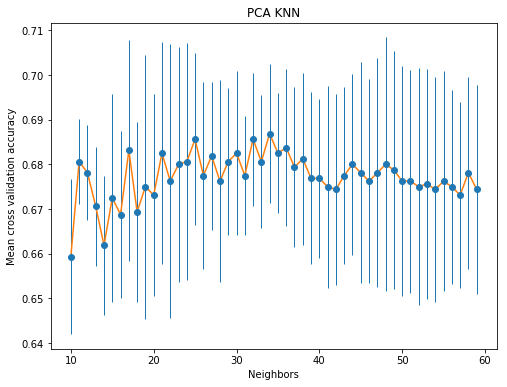

Best Number of Neighbors: 34

Test score for Optimized KNN: 0.695760598504


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier




#Initialize K-Fold for cross validation
K = 5
kfold = KFold(n_splits=K, random_state=seed)

#Create Pipeline
estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('knn_clf', KNeighborsClassifier()))
reg_knn_pipe1 = Pipeline(estimators)
reg_knn_pipe1.set_params(knn_clf__algorithm='ball_tree',knn_clf__weights='uniform')

#Create a grid search over n_neighbors values
parameters = {
        'knn_clf__n_neighbors' : np.arange(10,60)
}
estimator_knnreg = GridSearchCV(reg_knn_pipe1, parameters, cv=kfold)
                  
#Evaluate the grid search and print best regressor
print('Starting Grid Search')
estimator_knnreg.fit(X_train, y_train)

alphas = [x['knn_clf__n_neighbors'] for x in estimator_knnreg.cv_results_['params']]
means = [x for x in estimator_knnreg.cv_results_['mean_test_score']]
stds = [x for x in estimator_knnreg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('Neighbors')
plt.ylabel('Mean cross validation accuracy')
plt.title('PCA KNN')
plt.show()

reg_knn_pipe1.set_params(knn_clf__n_neighbors = estimator_knnreg.best_params_['knn_clf__n_neighbors'])
reg_knn_pipe1.fit(X_train, y_train)

print("Best Number of Neighbors:", estimator_knnreg.best_params_['knn_clf__n_neighbors'])
print ('\nTest score for Optimized KNN:', reg_knn_pipe1.score(X_test,y_test))

KNN does not outperform greatly the Dummy Classifier, moreover the results suffer from high variance.<br>
Some trees with feature importance analysis:

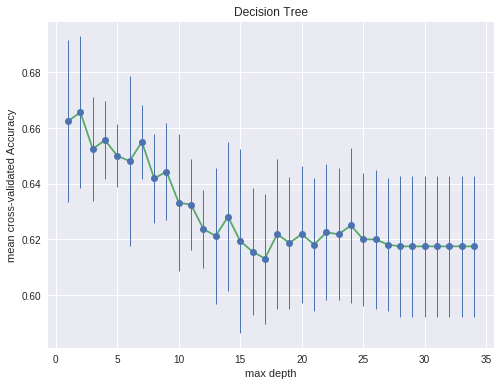


Best max depth --->    2

Test score --->    0.675810473815

Feature importances:



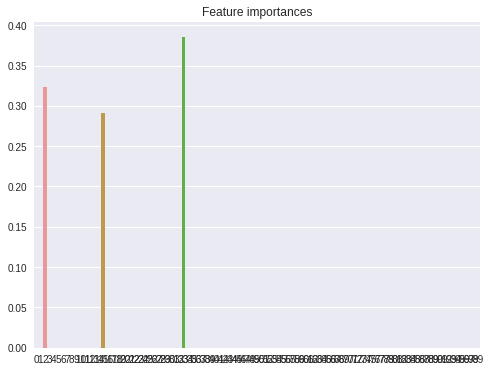


Bagging Test score --->    0.690773067332


In [5]:
#TREES

from sklearn.ensemble import BaggingClassifier
from sklearn import tree
import seaborn as sns



K = 5
kfold = KFold(n_splits=K, random_state=seed)


n_tried=35
depths=np.arange(1,n_tried)

estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('tree_cla', tree.DecisionTreeClassifier(random_state=seed)))
cla_tree_pipe1 = Pipeline(estimators)

parameters = {
        'tree_cla__max_depth' : depths
}
estimator_treecla = GridSearchCV(cla_tree_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_treecla.fit(X_train, y_train)

alphas = [x['tree_cla__max_depth'] for x in estimator_treecla.cv_results_['params']]
means = [x for x in estimator_treecla.cv_results_['mean_test_score']]
stds = [x for x in estimator_treecla.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('max depth')
plt.ylabel('mean cross-validated Accuracy')
plt.title('Decision Tree')
plt.show()

print('\nBest max depth --->   ',estimator_treecla.best_params_['tree_cla__max_depth'])

cla_tree_pipe1.set_params(tree_cla__max_depth = estimator_treecla.best_params_['tree_cla__max_depth'])
cla_tree_pipe1.fit(X_train, y_train)
acc_b = cla_tree_pipe1.score(X_test, y_test)
print ('\nTest score --->   ', acc_b)
print ('\nFeature importances:\n')
importances = cla_tree_pipe1.named_steps['tree_cla'].feature_importances_
indices = np.argsort(importances)[::-1]


# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.title("Feature importances")
sns.barplot(indices, y=importances[indices])
plt.show()


estimators = []
estimators.append(('Normalizer', Normalizer()))
estimators.append(('bag_cla', BaggingClassifier()))
cla_bag_pipe1 = Pipeline(estimators)
cla_bag_pipe1.set_params(bag_cla__base_estimator=tree.DecisionTreeClassifier(max_depth=estimator_treecla.best_params_['tree_cla__max_depth']),\
                         bag_cla__n_estimators=500, bag_cla__random_state=seed)

cla_bag_pipe1.fit(X_train,y_train)
acc_c=cla_bag_pipe1.score(X_test, y_test)
print ('\nBagging Test score --->   ', acc_c)

Again, we are quite disappointed. And at last a linear and Gaussian SVM with a Logistic Regression:

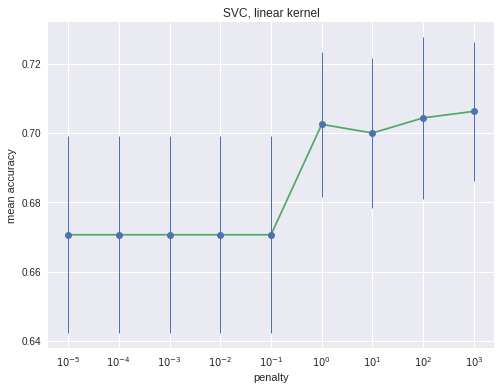


Best penalty for linear kernel --->    1000.0

Linear kernel test score --->    0.745635910224


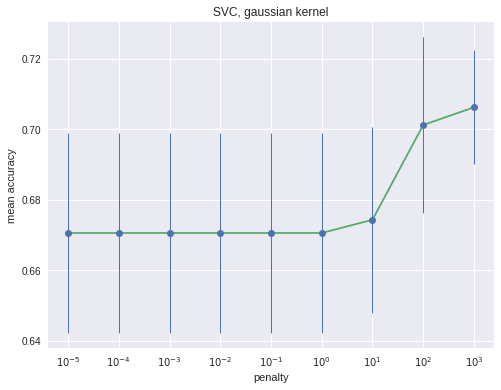


Best penalty for Gaussian kernel --->    1000.0

Test score --->    0.733167082294


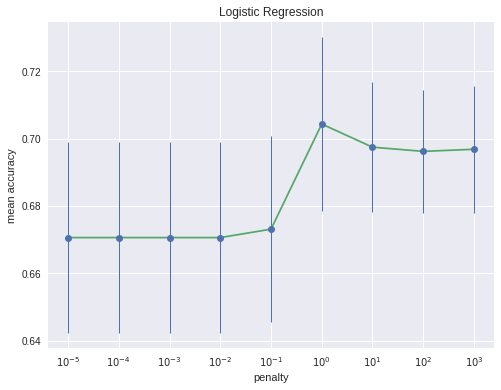


Best penalty for Logistic Regression --->    1.0

Logistic regression test score --->    0.743142144638


In [6]:
#SVM AND LOGISTIC

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
                  


K = 5
kfold = KFold(n_splits=K, random_state=seed)

# LINEAR KERNEL
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('svm_linear_clf', SVC()))
svm_linear_pipe1 = Pipeline(estimators)
svm_linear_pipe1.set_params(svm_linear_clf__kernel='linear', svm_linear_clf__gamma='auto')

penalties = np.logspace(-5,3,9)


parameters = {
        'svm_linear_clf__C' : penalties
}
estimator_svm_linear = GridSearchCV(svm_linear_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_svm_linear.fit(X_train,y_train)

alphas = [x['svm_linear_clf__C'] for x in estimator_svm_linear.cv_results_['params']]
means = [x for x in estimator_svm_linear.cv_results_['mean_test_score']]
stds = [x for x in estimator_svm_linear.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean accuracy')
plt.title('SVC, linear kernel')
plt.xscale('log')
plt.show()

print('\nBest penalty for linear kernel --->   ',estimator_svm_linear.best_params_['svm_linear_clf__C'])

svm_linear_pipe1.set_params(svm_linear_clf__C = estimator_svm_linear.best_params_['svm_linear_clf__C'])
svm_linear_pipe1.fit(X_train,y_train)
accuracy_b = svm_linear_pipe1.score(X_test,y_test)
print ('\nLinear kernel test score --->   ', accuracy_b)



# GAUSSIAN KERNEL
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('svm_gaussian_clf', SVC()))
svm_gaussian_pipe1 = Pipeline(estimators)
#No gridsearch on gamma, since 'auto' gave best results
svm_gaussian_pipe1.set_params(svm_gaussian_clf__kernel='rbf', svm_gaussian_clf__gamma='auto')

penalties = np.logspace(-5,3,9)


parameters = {
        'svm_gaussian_clf__C' : penalties
}
estimator_svm_gaussian = GridSearchCV(svm_gaussian_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_svm_gaussian.fit(X_train,y_train)

alphas = [x['svm_gaussian_clf__C'] for x in estimator_svm_gaussian.cv_results_['params']]
means = [x for x in estimator_svm_gaussian.cv_results_['mean_test_score']]
stds = [x for x in estimator_svm_gaussian.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean accuracy')
plt.title('SVC, gaussian kernel')
plt.xscale('log')
plt.show()

print('\nBest penalty for Gaussian kernel --->   ',estimator_svm_gaussian.best_params_['svm_gaussian_clf__C'])

svm_gaussian_pipe1.set_params(svm_gaussian_clf__C = estimator_svm_gaussian.best_params_['svm_gaussian_clf__C'])
svm_gaussian_pipe1.fit(X_train,y_train)
accuracy_b = svm_gaussian_pipe1.score(X_test,y_test)
print ('\nTest score --->   ', accuracy_b)



# LOGISTIC REGRESSION
estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('log_reg', LogisticRegression()))
log_reg_pipe1 = Pipeline(estimators)
log_reg_pipe1.set_params()

penalties = np.logspace(-5,3,9)


parameters = {
        'log_reg__C' : penalties
}
estimator_log_reg = GridSearchCV(log_reg_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_log_reg.fit(X_train,y_train)

alphas = [x['log_reg__C'] for x in estimator_log_reg.cv_results_['params']]
means = [x for x in estimator_log_reg.cv_results_['mean_test_score']]
stds = [x for x in estimator_log_reg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean accuracy')
plt.title('Logistic Regression')
plt.xscale('log')
plt.show()

print('\nBest penalty for Logistic Regression --->   ',estimator_log_reg.best_params_['log_reg__C'])

log_reg_pipe1.set_params(log_reg__C = estimator_log_reg.best_params_['log_reg__C'])
log_reg_pipe1.fit(X_train,y_train)
accuracy_c = log_reg_pipe1.score(X_test,y_test)
print ('\nLogistic regression test score --->   ', accuracy_c)

Again the parametric models have the best performance among all of them. We ran the code with more data and we have already seen that the Logistic regression is the fastest and most flexible model in terms of computational speed so we chose this model also in this step.<br>
<br>
We want to study again the effect of the dimension of the data with a learning curve. But first we have to do some preprocessing again:

Begin Preprocessing
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/INTRANET/mpietrob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
no english:  ['styled', 'introverted', 'album', 'memory', 'tree', 'masterpiece', 'subtlety', 'song', 'endearing', 'shyness', 'soft', 'piano', 'lovely', 'quiet', 'voice', 'inferno', 'let', 'explode', 'couple', 'song', 'absolutely', 'burst', 'expected', 'raw', 'power', 'heard', 'want', 'start', 'popularized', 'work', 'like', 'watermark', 'play', 'safe', 'fan', 'collection', 'complete', 'beautiful', 'work', 'musical', 'art'] 

Dictionary(17899 unique tokens: ['hard', 'believe', 'memory', 'tree', 'came']...)
Finished Preprocessing
Computing Learning Curve


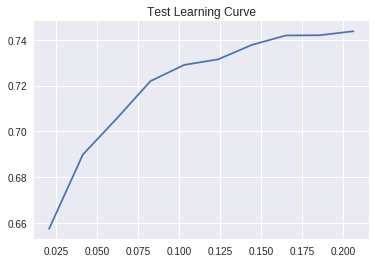

In [8]:
import pandas as pd

seed = 123

df_complete = pd.read_json(path_or_buf = 'data/reviews_Digital_Music_5.json', lines=True)
df = pd.DataFrame(df_complete[['asin', 'overall','reviewText']])
df = df.ix[:20000,:]
del df_complete

print('Begin Preprocessing')


five_stars = (df['overall']==5)*1.0

             

df_refined=[]
for item in df.ix[:,2]:
    df_refined.append (item.replace('\r',' ').replace('/n',' ').replace('.',' ')\
                           .replace(',',' ').replace('(',' ').replace(')',' ')\
                           .replace("'s",' ').replace('"',' ').replace('!',' ')\
                           .replace('?',' ').replace("'",' ').replace('>',' ')\
                           .replace('$',' ').replace('-',' ').replace(';',' ')\
                           .replace(':',' ').replace('/',' ').replace('#',' '))


from gensim import corpora
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk import download

download('wordnet')

tester = 1
lemmatizer = WordNetLemmatizer()
documents = df_refined



documents_no_stop = [[word for word in document.lower().split() if word not in STOPWORDS]
         for document in documents]

del documents

# remove words that appear only once
from collections import defaultdict
threshold = 1 # frequency threshold
frequency = defaultdict(int)
for text in documents_no_stop:
    for token in text:
        frequency[token] += 1

documents_no_stop_no_unique = [[token for token in text if frequency[token] > threshold] 
                               for text in documents_no_stop]

del documents_no_stop


import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
documents_no_stop_no_unique_no_numeric = [[token for token in text if not (hasNumbers(token)) ] 
                                          for text in documents_no_stop_no_unique]

del documents_no_stop_no_unique


# lemmattizing tokens (better than stemming by taking word context into account)
documents_no_stop_no_unique_no_numeric_lemmatize = [[lemmatizer.lemmatize(token) for token in text] 
                                                    for text in documents_no_stop_no_unique_no_numeric]

del documents_no_stop_no_unique_no_numeric


import enchant
eng_dic = enchant.Dict("en_US")

# remove non-english words
documents_no_stop_no_unique_no_numeric_lemmatize_english = [[token for token in text if (eng_dic.check(token)) ] 
                                                            for text in documents_no_stop_no_unique_no_numeric_lemmatize]

print ('no english: ',documents_no_stop_no_unique_no_numeric_lemmatize_english[tester], '\n')
del documents_no_stop_no_unique_no_numeric_lemmatize



# create ready corpus
ready_corpus = documents_no_stop_no_unique_no_numeric_lemmatize_english


# build the dictionary and store it to disc for future use
dictionary = corpora.Dictionary(ready_corpus)
print(dictionary)


# convert the corpus into bag of words 
corpus_bow = [dictionary.doc2bow(comment) for comment in ready_corpus]


import os
from gensim import corpora, models, matutils

    

from sklearn.model_selection import train_test_split

tfidf_transformer = models.TfidfModel(corpus_bow, normalize=True)

# apply tfidf transformation to the bow corpus
corpus_tfidf = tfidf_transformer [corpus_bow]


# convert to a sparse and compatible format for dimensionality reduction using sklearn
sparse_corpus_tfidf = matutils.corpus2csc(corpus_tfidf)
sparse_corpus_tfidf_transpose = sparse_corpus_tfidf.transpose()


train_tfidf, test_tfidf, train_category, test_category = train_test_split(sparse_corpus_tfidf_transpose, five_stars, test_size = 0.2, random_state = seed)

print('Finished Preprocessing')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

%matplotlib inline

#Initialize Logistic Regression
log_reg = LogisticRegression(C=1.0)


#Compute and Plot learning curve
print("Computing Learning Curve")
train_sizes, train_scores, test_scores = learning_curve(log_reg, sparse_corpus_tfidf_transpose, five_stars, train_sizes = np.linspace(0.1,1,10), cv=3)

plt.plot(train_sizes/64706, test_scores.mean(axis=1))
plt.title("Test Learning Curve")

This time we have that the learning curve is steeper with respect to step 1, thus we need even more data to be able to achieve a better lift on the dummy classifier. In light of this we also would like to re-tune our favorite model, the logistic regression, in order to achieve a better performance in the "unseen" set.

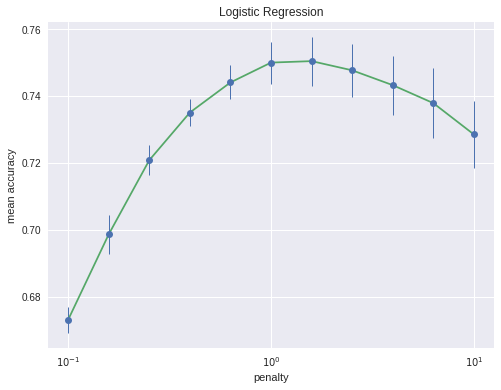


Best penalty for Logistic Regression --->    1.58489319246

Logistic regression test score --->    0.774056485879


In [9]:
X_train = train_tfidf
X_test =  test_tfidf
y_train =  train_category
y_test =  test_category


estimators = []
estimators.append(('normalizer', Normalizer()))
estimators.append(('log_reg', LogisticRegression()))
log_reg_pipe1 = Pipeline(estimators)
log_reg_pipe1.set_params()

penalties = np.logspace(-1,1,11)


parameters = {
        'log_reg__C' : penalties
}
estimator_log_reg = GridSearchCV(log_reg_pipe1, parameters, cv=kfold)
                  
# evaluate the grid search and print best classifier
estimator_log_reg.fit(X_train,y_train)

alphas = [x['log_reg__C'] for x in estimator_log_reg.cv_results_['params']]
means = [x for x in estimator_log_reg.cv_results_['mean_test_score']]
stds = [x for x in estimator_log_reg.cv_results_['std_test_score']]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, stds, fmt='o', lw=1)
plt.plot(alphas, means)
plt.xlabel('penalty')
plt.ylabel('mean accuracy')
plt.title('Logistic Regression')
plt.xscale('log')
plt.show()

print('\nBest penalty for Logistic Regression --->   ',estimator_log_reg.best_params_['log_reg__C'])

log_reg_pipe1.set_params(log_reg__C = estimator_log_reg.best_params_['log_reg__C'])
log_reg_pipe1.fit(X_train,y_train)
accuracy_final = log_reg_pipe1.score(X_test,y_test)
print ('\nLogistic regression test score --->   ', accuracy_final)

We wanted to analyze the effect of changing the threshold on the logistic regression prediction method. We found out that the regression improves the performance if the threshold is increased (harder to predict the most common class). On the other hand, reading some papers we found out that the logistic regression is a very robust model with respect to imbalances in the samples (that is our case where the 1 class is much more frequent). This means that the optimal threshold asymthotically converges to 0.5. We did some tries with more samples and empirically verified this fact, therefore we consider threshold optimization not a solution to improve our performances.

In conclusion, we have again that more data and consequently more computational power would help us allowing us to carry more complex optimizations and obtain more stable results. 